# Using Machine Learning to Forecast Air Quality in Beijing

In [1]:
# Beijing PM 2.5
# Springboard Capstone Project I

%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as st
from scipy.stats.stats import pearsonr

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
# Data obtained from UCI Repository (https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities)
df_Beijing = pd.read_csv('BeijingPM20100101_20151231.csv')
df_Beijing.info()
df_Beijing.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 18 columns):
No                 52584 non-null int64
year               52584 non-null int64
month              52584 non-null int64
day                52584 non-null int64
hour               52584 non-null int64
season             52584 non-null int64
PM_Dongsi          25052 non-null float64
PM_Dongsihuan      20508 non-null float64
PM_Nongzhanguan    24931 non-null float64
PM_US Post         50387 non-null float64
DEWP               52579 non-null float64
HUMI               52245 non-null float64
PRES               52245 non-null float64
TEMP               52579 non-null float64
cbwd               52579 non-null object
Iws                52579 non-null float64
precipitation      52100 non-null float64
Iprec              52100 non-null float64
dtypes: float64(11), int64(6), object(1)
memory usage: 7.2+ MB


,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


In [3]:
df_Beijing.index = pd.to_datetime(df_Beijing.year*1000000 + df_Beijing.month*10000 + df_Beijing.day*100 + df_Beijing.hour, format='%Y%m%d%H')

In [4]:
df_Beijing = df_Beijing.rename(columns={'PM_US Post': 'pm25', 'DEWP': 'dew_point',
                       'HUMI': 'humidity', 'PRES': 'pressure',
                       'TEMP' : 'temp', 'cbwd': 'wind_dir',
                       'Iws': 'wind_speed'})

In [5]:
df = df_Beijing.copy()

In [6]:
df = df.loc[:,'pm25':'precipitation']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52584 entries, 2010-01-01 00:00:00 to 2015-12-31 23:00:00
Data columns (total 8 columns):
pm25             50387 non-null float64
dew_point        52579 non-null float64
humidity         52245 non-null float64
pressure         52245 non-null float64
temp             52579 non-null float64
wind_dir         52579 non-null object
wind_speed       52579 non-null float64
precipitation    52100 non-null float64
dtypes: float64(7), object(1)
memory usage: 3.6+ MB


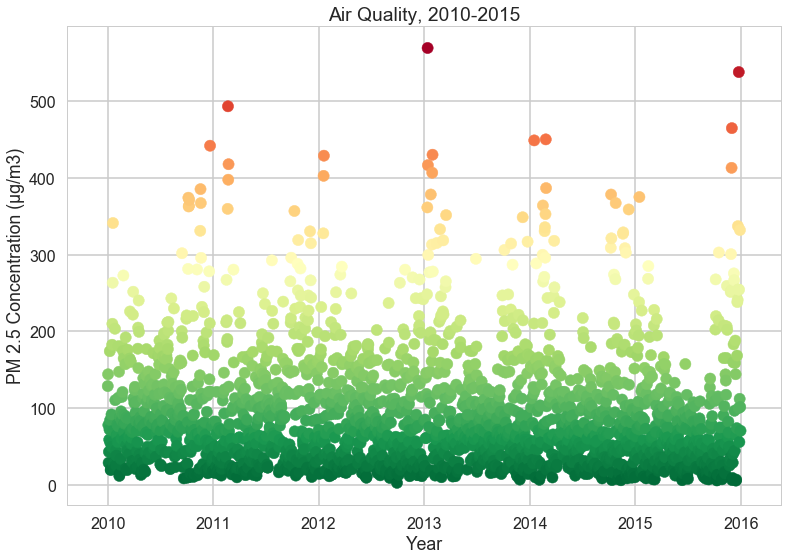

In [8]:
scatter_y = df.pm25.resample('D').mean()
scatter_x = df.pm25.resample('D').mean().index
color = scatter_y

plt.scatter(x = scatter_x, y = scatter_y, c = color, cmap = 'RdYlGn_r') # For later: Shift colormap down
plt.xlabel('Year')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality, 2010-2015')

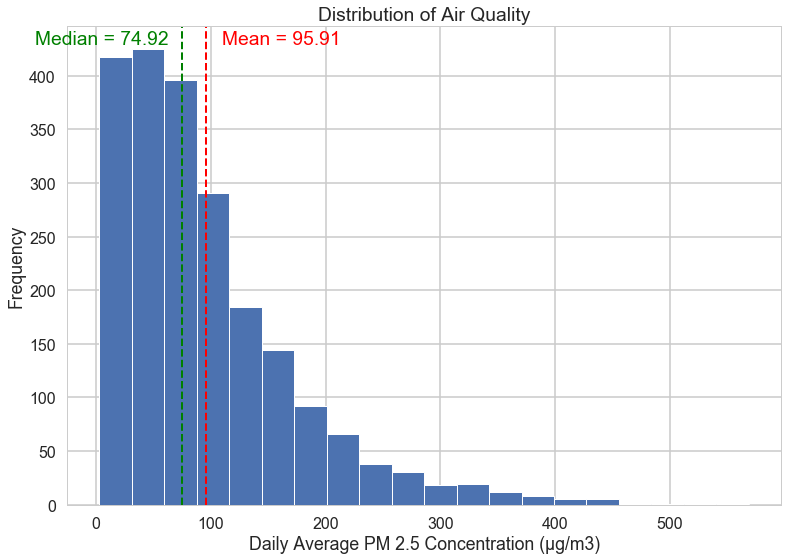

In [9]:
# Distribution of air quality for the period 2010-2015
plt.figure()
plt.hist(scatter_y.dropna(), bins = 20, edgecolor='w', lw=1)
plt.xlabel('Daily Average PM 2.5 Concentration (μg/m3)')
plt.ylabel('Frequency')
plt.title('Distribution of Air Quality')
plt.text(110, 430, 'Mean = ' + str(round(scatter_y.dropna().mean(),2)), color = 'red')
plt.text(-53, 430, 'Median = ' + str(round(scatter_y.dropna().median(),2)), color = 'green')
plt.axvline(scatter_y.dropna().mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(scatter_y.dropna().median(), color='g', linestyle='dashed', linewidth=2)

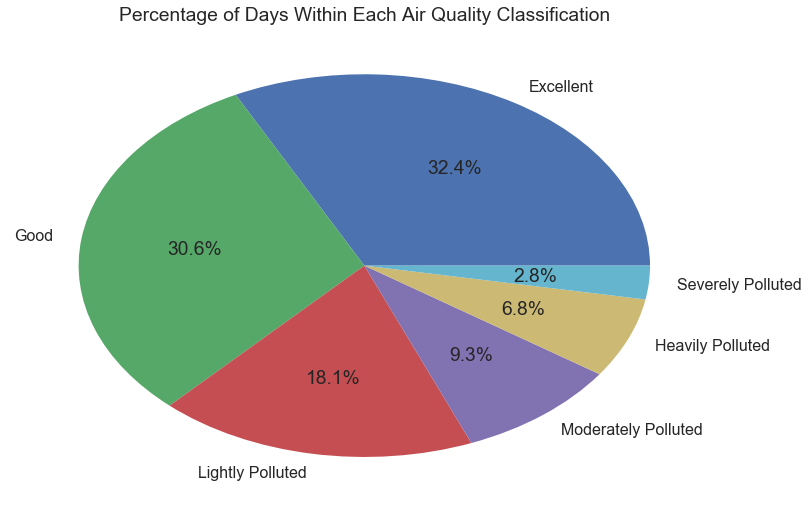

In [10]:
excellent = len([ii for ii in scatter_y.dropna() if ii <= 50])
good = len([ii for ii in scatter_y.dropna() if ii > 50 and ii <= 100])
lightly = len([ii for ii in scatter_y.dropna() if ii > 100 and ii <= 150])
moderately = len([ii for ii in scatter_y.dropna() if ii > 150 and ii <= 200])
heavily = len([ii for ii in scatter_y.dropna() if ii > 200 and ii <= 300])
severely = len([ii for ii in scatter_y.dropna() if ii > 300])
sizes = [excellent, good, lightly, moderately, heavily, severely]
labels = ['Excellent','Good','Lightly Polluted','Moderately Polluted','Heavily Polluted','Severely Polluted']
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Percentage of Days Within Each Air Quality Classification')

([<matplotlib.axis.XTick at 0x114f349b0>,
 <a list of 12 Text xticklabel objects>)

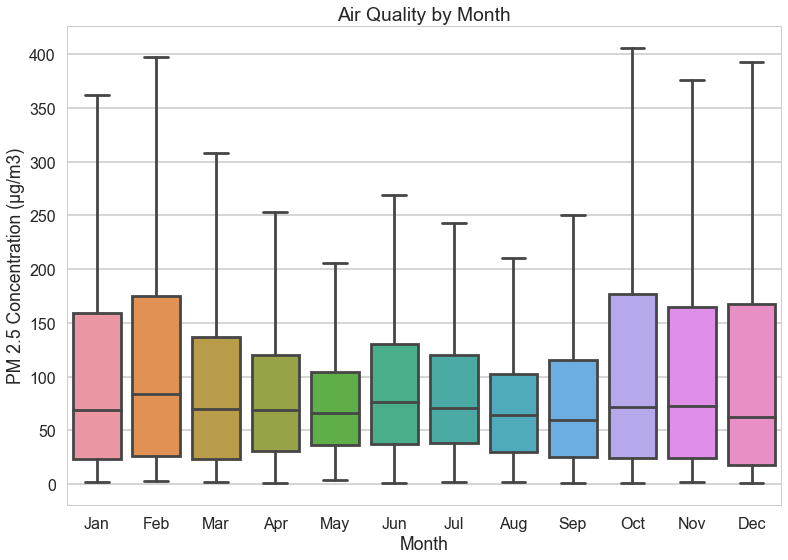

In [11]:
# Plot PM 2.5 level by month
plt.figure()
sns.boxplot(x="month", y="pm25", data=df_Beijing, showfliers=False)
plt.xlabel('Month')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Month')
plt.xticks(range(0,12), calendar.month_abbr[1:13])

In [12]:
# Plot PM 2.5 level by day of the week

df_length, df_width = df_Beijing.shape

weekday = []

for ii in list(range(df_length)):
    weekday.append(calendar.weekday(df_Beijing.year[ii],
        df_Beijing.month[ii], df_Beijing.day[ii]))
    
df['weekday'] = weekday

([<matplotlib.axis.XTick at 0x115530160>,
 <a list of 7 Text xticklabel objects>)

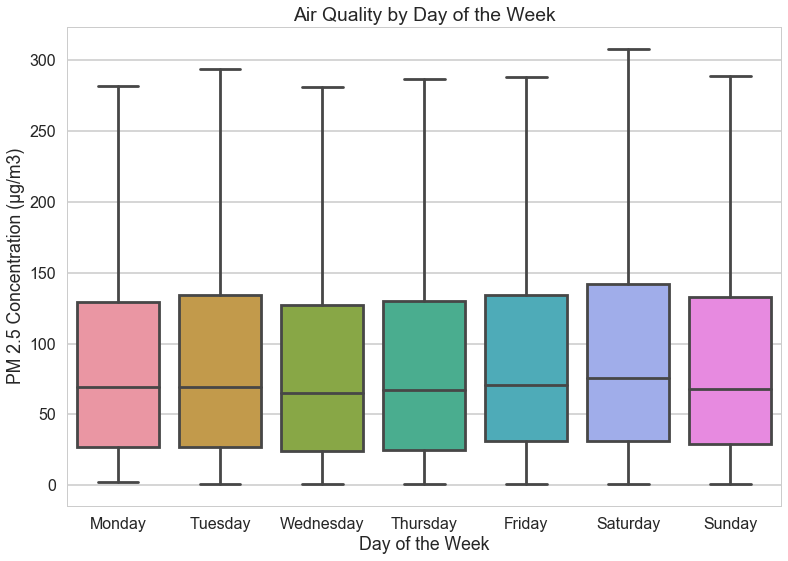

In [13]:
plt.figure()
sns.boxplot(x="weekday", y="pm25", data=df, showfliers=False)
plt.xlabel('Day of the Week')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Day of the Week')
plt.xticks(range(0,7), calendar.day_name)

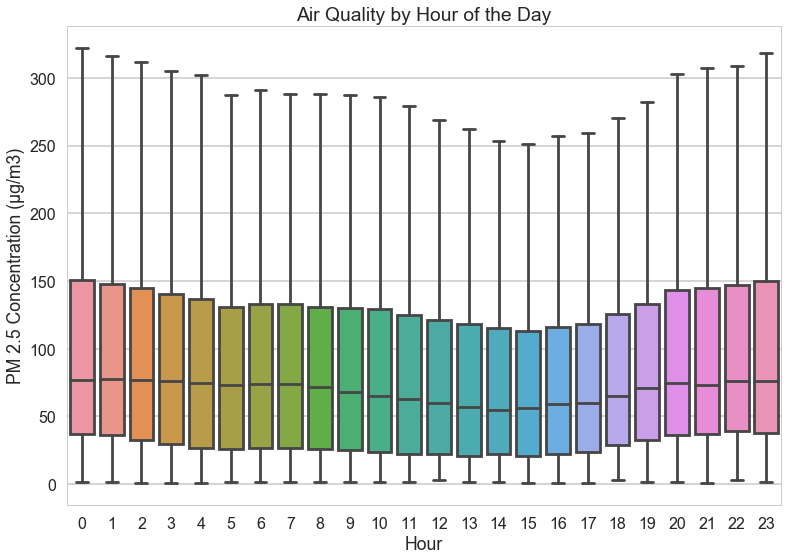

In [14]:
# Plot PM 2.5 level by hour of the day

plt.figure()
sns.boxplot(x="hour", y="pm25", data=df_Beijing, showfliers=False)
plt.xlabel('Hour')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Hour of the Day')

In [15]:
# Then plot others against dependent parameters (temperature, pressure, etc...)

/Users/kevinlimkrailassiri/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


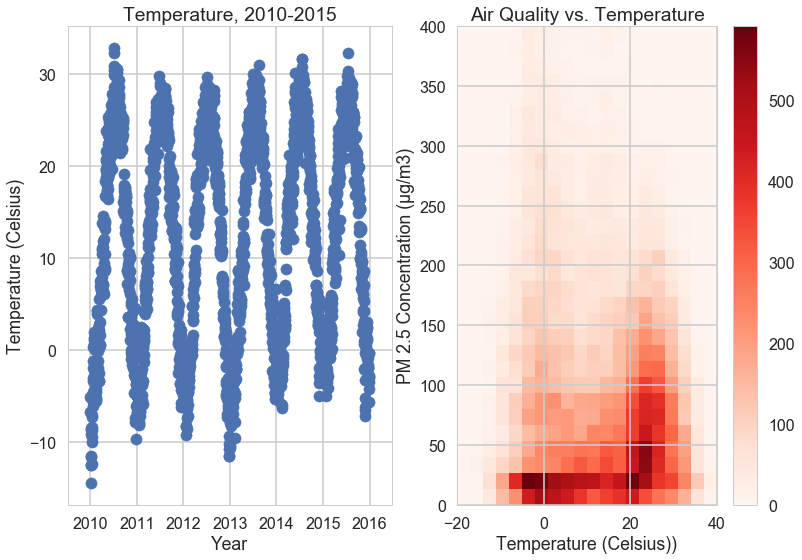

In [16]:
# Temperature

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.temp.resample('D').mean().index, y = df.temp.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Temperature (Celsius)')
plt.title('Temperature, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.temp, y = df.pm25, bins = (20, 30), range = ((-20,40),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Temperature (Celsius))')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Temperature')

/Users/kevinlimkrailassiri/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


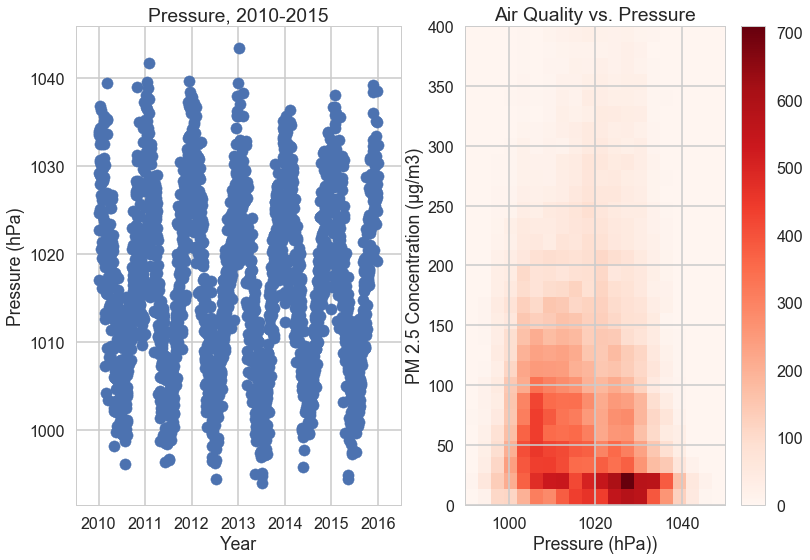

In [17]:
# Pressure

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.pressure.resample('D').mean().index, y = df.pressure.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Pressure (hPa)')
plt.title('Pressure, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.pressure, y = df.pm25, bins = (20, 30), range = ((990,1050),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Pressure (hPa))')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Pressure')

/Users/kevinlimkrailassiri/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


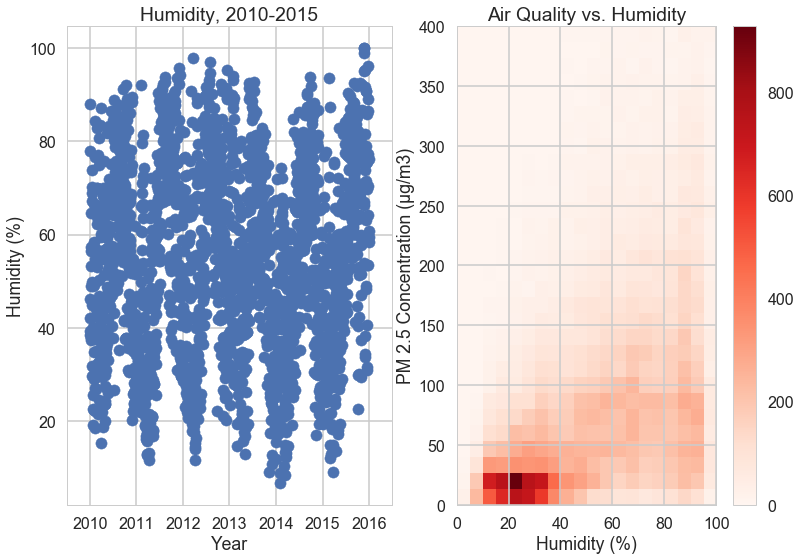

In [18]:
# Humidity

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.humidity.resample('D').mean().index, y = df.humidity.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Humidity (%)')
plt.title('Humidity, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.humidity, y = df.pm25, bins = (20, 30), range = ((0,100),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Humidity (%)')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Humidity')

/Users/kevinlimkrailassiri/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


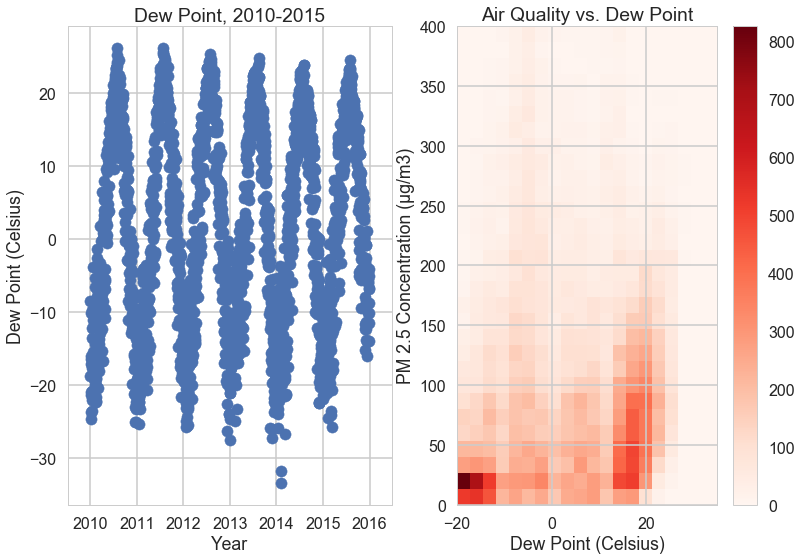

In [19]:
# Dew Point

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.dew_point.resample('D').mean().index, y = df.dew_point.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Dew Point (Celsius)')
plt.title('Dew Point, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.dew_point, y = df.pm25, bins = (20, 30), range = ((-20,35),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Dew Point (Celsius)')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Dew Point')

/Users/kevinlimkrailassiri/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


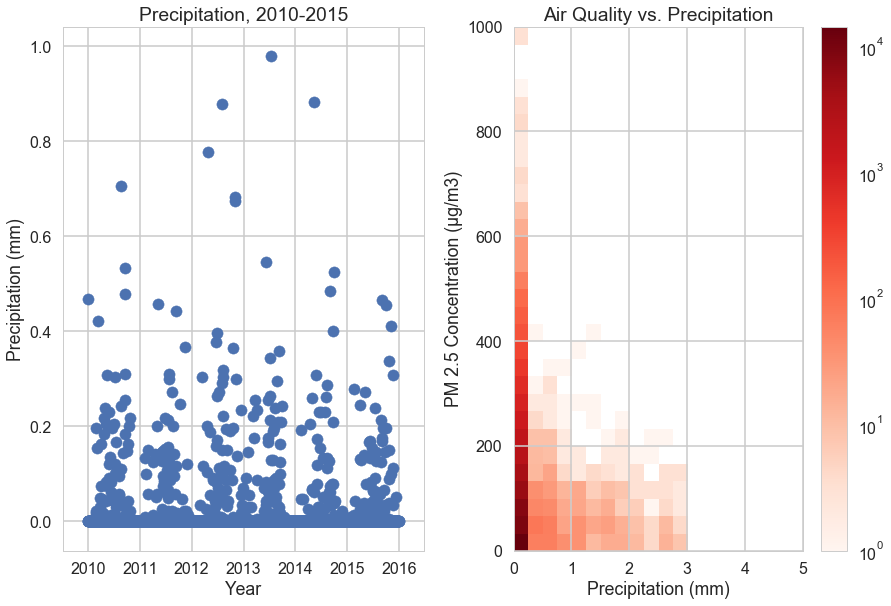

In [20]:
# Precipitation

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df[df.precipitation < 3].precipitation.resample('D').mean().index, y = df[df.precipitation < 3].precipitation.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title('Precipitation, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df[df.precipitation < 3].precipitation, y = df[df.precipitation < 3].pm25,
           bins = (20, 30), range = ((0,5),(0,1000)), cmap = 'Reds', norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('Precipitation (mm)')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Precipitation')

plt.tight_layout()

In [21]:
# Wind Speed Sorted by Wind Direction
from collections import Counter

Counter(df.wind_dir)

Counter({'NW': 16717, 'cv': 11412, 'NE': 6178, 'SE': 18272, nan: 5})

([<matplotlib.axis.YTick at 0x1182e85f8>,
 <a list of 6 Text yticklabel objects>)

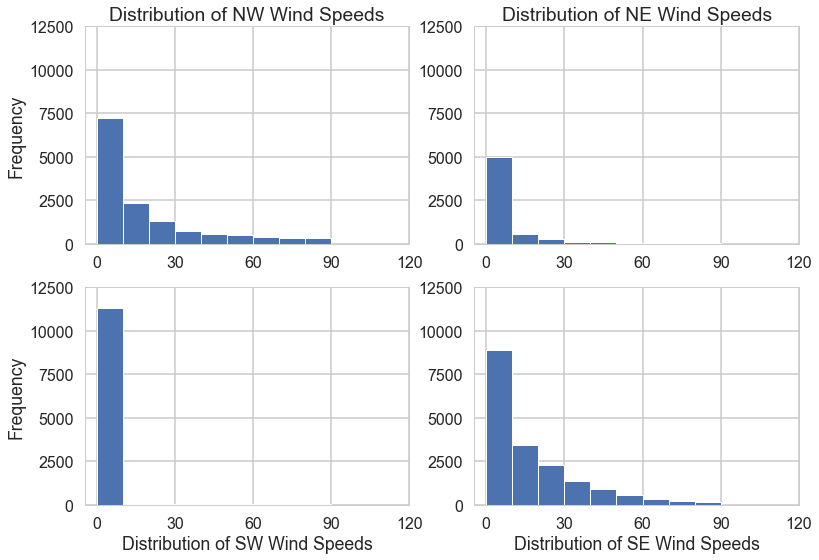

In [22]:
# NW

NW_pm25 = df.pm25[df.wind_dir == 'NW']
NW_wind_speed = df.wind_speed[df.wind_dir == 'NW']

plt.figure()
plt.subplot(2,2,1)
plt.hist(NW_wind_speed, bins = range(0,100,10), edgecolor='w', lw=1)
plt.ylabel('Frequency')
plt.title('Distribution of NW Wind Speeds')
plt.xticks(np.arange(0,150,30))
plt.yticks(np.arange(0,15000,2500))

# NE

NE_pm25 = df.pm25[df.wind_dir == 'NE']
NE_wind_speed = df.wind_speed[df.wind_dir == 'NE']

plt.subplot(2,2,2)
plt.hist(NE_wind_speed, bins = range(0,100,10), edgecolor='w', lw=1)
plt.title('Distribution of NE Wind Speeds')
plt.xticks(np.arange(0,150,30))
plt.yticks(np.arange(0,15000,2500))

# SW

SW_pm25 = df.pm25[df.wind_dir == 'cv']
SW_wind_speed = df.wind_speed[df.wind_dir == 'cv']

plt.subplot(2,2,3)
plt.hist(SW_wind_speed, bins = range(0,100,10), edgecolor='w', lw=1)
plt.xlabel('Distribution of SW Wind Speeds')
plt.ylabel('Frequency')
plt.xticks(np.arange(0,150,30))
plt.yticks(np.arange(0,15000,2500))

# SE

SE_pm25 = df.pm25[df.wind_dir == 'SE']
SE_wind_speed = df.wind_speed[df.wind_dir == 'SE']

plt.subplot(2,2,4)
plt.hist(SE_wind_speed, bins = range(0,100,10), edgecolor='w', lw=1)
plt.xlabel('Distribution of SE Wind Speeds')
plt.xticks(np.arange(0,150,30))
plt.yticks(np.arange(0,15000,2500))

/Users/kevinlimkrailassiri/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


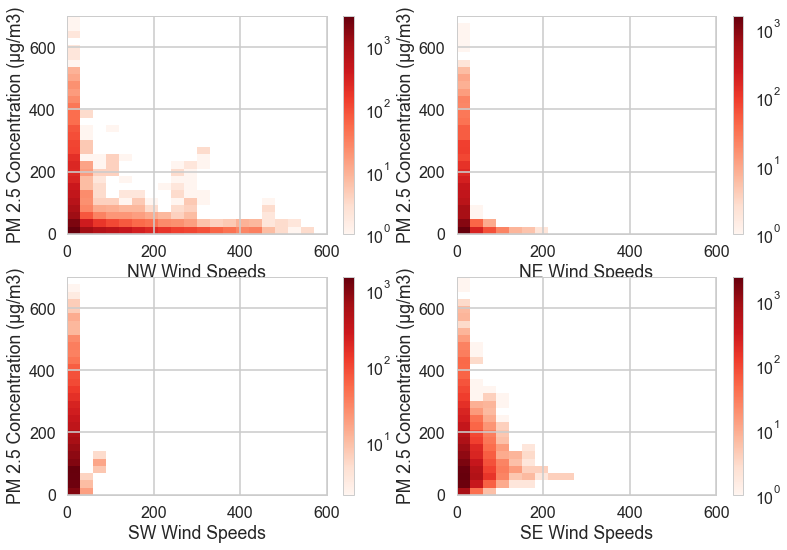

In [51]:
# NW

plt.figure()
plt.subplot(2,2,1)
plt.hist2d(x = df.wind_speed[df.wind_dir == 'NW'], y = df.pm25[df.wind_dir == 'NW'],
           bins = (20, 30), range = ((0,600),(0,700)), cmap = 'Reds', norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('NW Wind Speeds')
plt.ylabel('PM 2.5 Concentration (μg/m3)')

# NE

plt.subplot(2,2,2)
plt.hist2d(x = df.wind_speed[df.wind_dir == 'NE'], y = df.pm25[df.wind_dir == 'NE'],
           bins = (20, 30), range = ((0,600),(0,700)), cmap = 'Reds', norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('NE Wind Speeds')
plt.ylabel('PM 2.5 Concentration (μg/m3)')

# SW

plt.subplot(2,2,3)
plt.hist2d(x = df.wind_speed[df.wind_dir == 'cv'], y = df.pm25[df.wind_dir == 'cv'],
           bins = (20, 30), range = ((0,600),(0,700)), cmap = 'Reds', norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('SW Wind Speeds')
plt.ylabel('PM 2.5 Concentration (μg/m3)')

# SE

plt.subplot(2,2,4)
plt.hist2d(x = df.wind_speed[df.wind_dir == 'SE'], y = df.pm25[df.wind_dir == 'SE'],
           bins = (20, 30), range = ((0,600),(0,700)), cmap = 'Reds', norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('SE Wind Speeds')
plt.ylabel('PM 2.5 Concentration (μg/m3)')

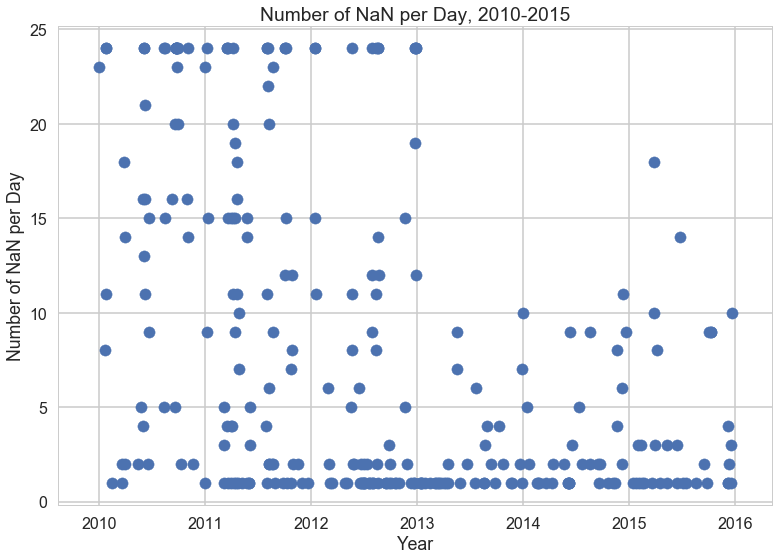

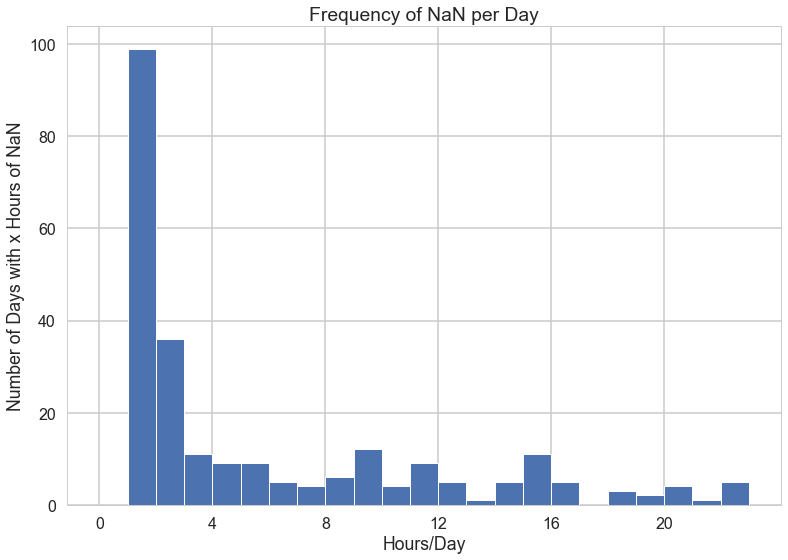

In [24]:
# How reliable is this measurement center? Also, how frequently do NaN appear each day?

dailyNaN = df.pm25.isnull().resample('D').sum()

plt.figure()
plt.title('Number of NaN per Day, 2010-2015')
plt.scatter(x = dailyNaN[dailyNaN > 0].index, y = dailyNaN[dailyNaN > 0])
plt.xlabel('Year')
plt.ylabel('Number of NaN per Day')

plt.figure()
plt.title('Frequency of NaN per Day')
plt.hist(dailyNaN[dailyNaN > 0], bins=range(0,24,1), edgecolor='w', lw=1)
plt.xticks(np.arange(0,24,4))
plt.xlabel('Hours/Day')
plt.ylabel('Number of Days with x Hours of NaN')

In [25]:
# Function consecNaN() constructs a list of the number of hours that the NaN's appear consecutively:
def consecNaN(NaNorNot):
    consecutive = []
    counter = 0
    before = False
    for ii in NaNorNot:
        if ii == True:
            if before == False:
                counter = 1
            else:
                counter += 1
            before = True
        else:
            if before == True:
                consecutive.append(counter)
            before = False
    return consecutive

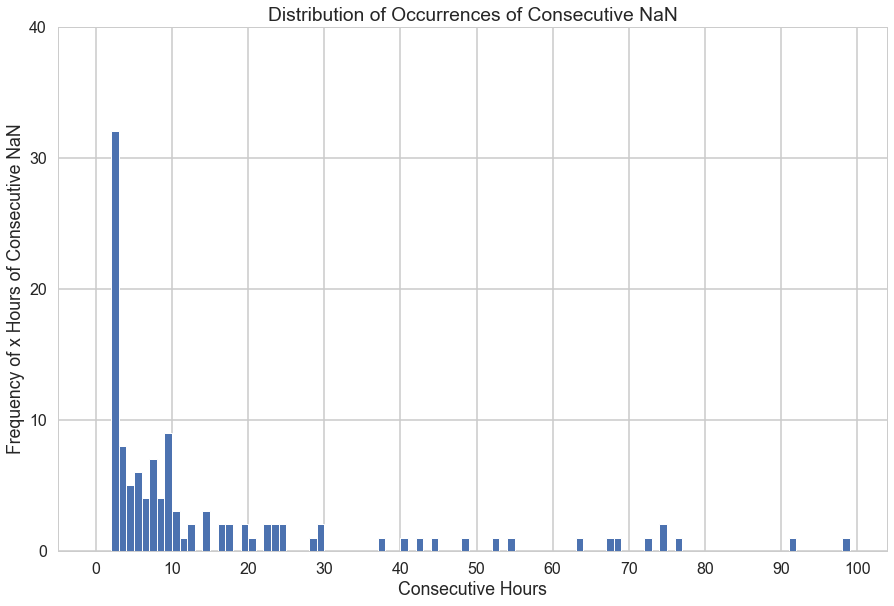

In [26]:
consecNaN_dist = consecNaN(df.pm25.isnull())
consecNaN_dist_over1 = [ii for ii in consecNaN_dist if ii > 1]

plt.figure()
plt.hist(consecNaN_dist_over1, bins=range(0,100,1), edgecolor='w', lw=1)
plt.title('Distribution of Occurrences of Consecutive NaN')
plt.xticks(np.arange(0,110,10))
plt.xlabel('Consecutive Hours')
plt.ylabel('Frequency of x Hours of Consecutive NaN')
plt.yticks(np.arange(0,50,10))
plt.tight_layout()

In [27]:
df_railways = pd.read_csv('NBSC-A070405_M.csv')
df_highways = pd.read_csv('NBSC-A070409_M.csv')
df_waterways = pd.read_csv('NBSC-A07040D_M.csv')
df_civilaviation = pd.read_csv('NBSC-A07040H_M.csv')

In [28]:
df_railways.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
Date     134 non-null object
Value    134 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.2+ KB


In [29]:
df_railways.head()

,Date,Value
0,2016-02-29,1256.57469
1,2016-01-31,1002.13000
2,2015-12-31,750.61000
3,2015-11-30,802.66473
4,2015-10-31,1004.34186


In [30]:
df_highways.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
Date     125 non-null object
Value    125 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB


In [31]:
df_waterways.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
Date     125 non-null object
Value    125 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB


In [32]:
df_civilaviation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
Date     134 non-null object
Value    134 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.2+ KB


In [33]:
df_transport = df_railways.copy()

In [34]:
df_transport = df_transport.set_index('Date')
del df_transport.index.name
df_transport.columns = ['rail']
df_transport = df_transport.sort_index(ascending = True)

In [35]:
df_transport.head()

,rail
2005-01-31,483.96
2005-02-28,623.19
2005-03-31,528.91
2005-04-30,476.69
2005-05-31,487.96


In [36]:
# Prime the dataframe

# Iterate over the dates_list 
def str2datetime(dates_list):
    dates_datetime = []
    for date_str in dates_list:
        # Convert each date to a datetime object: date_dt
        dates_datetime.append(datetime.strptime(date_str,"%Y-%m-%d"))
    return(dates_datetime)

In [37]:
highways_datetime = str2datetime(list(df_highways.Date))
df_highways.Date = pd.Series(highways_datetime)
df_highways = df_highways.set_index('Date')
df_highways.sort_index()
df_highways = df_highways.resample('M').mean()

waterways_datetime = str2datetime(list(df_waterways.Date))
df_waterways.Date = pd.Series(waterways_datetime)
df_waterways = df_waterways.set_index('Date')
df_waterways.sort_index()
df_waterways = df_waterways.resample('M').mean()

df_waterways.Value = df_waterways.Value.interpolate(method='linear')
df_highways.Value = df_highways.Value.interpolate(method='linear')

df_transport['high'] = df_highways
df_transport['water'] = df_waterways

In [38]:
df_transport.head()

,rail,high,water
2005-01-31,483.96,804.71,4.80
2005-02-28,623.19,1019.47,5.83
2005-03-31,528.91,765.91,5.11
2005-04-30,476.69,735.20,5.07
2005-05-31,487.96,782.96,5.77


In [39]:
df_transport.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134 entries, 2005-01-31 to 2016-02-29
Data columns (total 3 columns):
rail     134 non-null float64
high     134 non-null float64
water    134 non-null float64
dtypes: float64(3)
memory usage: 4.2+ KB


In [40]:
df_civilaviation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
Date     134 non-null object
Value    134 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.2+ KB


In [41]:
df_civilaviation = df_civilaviation.set_index('Date')
df_civilaviation = df_civilaviation.sort_index(ascending = True)
df_transport['aviation'] = df_civilaviation

In [42]:
df_transport.head()

,rail,high,water,aviation
2005-01-31,483.96,804.71,4.80,136.13
2005-02-28,623.19,1019.47,5.83,145.40
2005-03-31,528.91,765.91,5.11,151.44
2005-04-30,476.69,735.20,5.07,163.62
2005-05-31,487.96,782.96,5.77,163.13


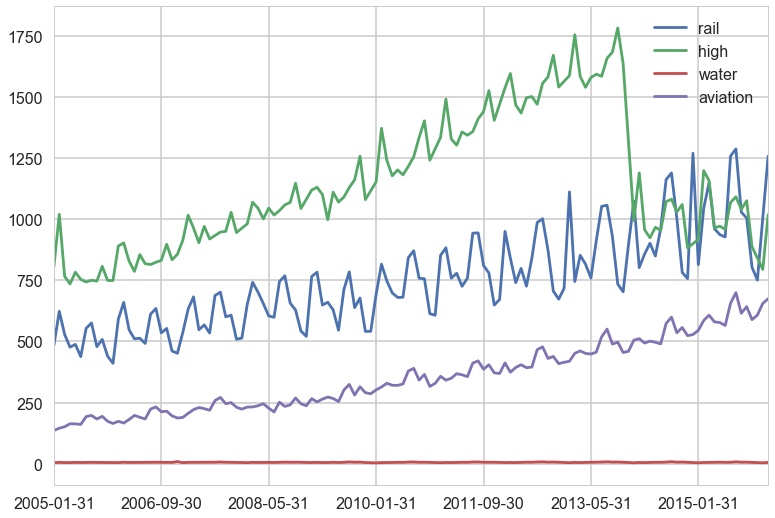

In [43]:
df_transport.plot()

In [44]:
more_than_2hrs = df.pm25.isnull().resample('D').sum() > 2
more_than_2hrs = more_than_2hrs[more_than_2hrs == True]

In [45]:
df_more_than_2hrs = []

for ii in more_than_2hrs.index:
    df_more_than_2hrs.append(df[str(datetime.date(ii))])
    
df_more_than_2hrs = pd.concat(df_more_than_2hrs, axis = 1)

In [46]:
df = df.drop(df_more_than_2hrs.index)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49056 entries, 2010-01-02 00:00:00 to 2015-12-31 23:00:00
Data columns (total 9 columns):
pm25             48885 non-null float64
dew_point        49052 non-null float64
humidity         48718 non-null float64
pressure         48718 non-null float64
temp             49052 non-null float64
wind_dir         49052 non-null object
wind_speed       49052 non-null float64
precipitation    48612 non-null float64
weekday          49056 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 3.7+ MB


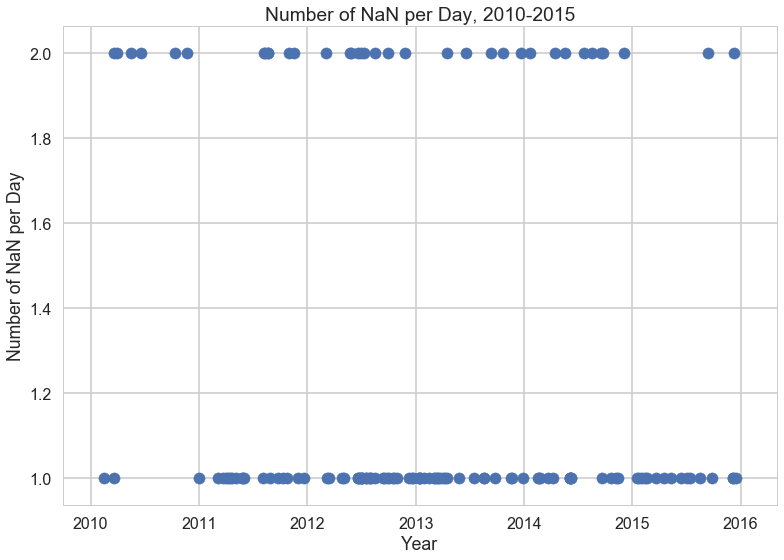

In [48]:
dailyNaN2 = df.pm25.isnull().resample('D').sum()

plt.figure()
plt.title('Number of NaN per Day, 2010-2015')
plt.scatter(x = dailyNaN2[dailyNaN2 > 0].index, y = dailyNaN2[dailyNaN2 > 0])
plt.xlabel('Year')
plt.ylabel('Number of NaN per Day')